# Caso BOPS

**Resumen del problema**

Objetivo de Home & Kitchen: Ventas habian crecido por 5 años pero luego se estabilizaron, quieren continuar creciendo

BOPS: Buy Online Pickup at Store 

* Ventajas: 

    * Ahorro en costos de envio y entregas el mismo dia

* Desventajas:

    * Cooperación entre B&M y online
    * B&M tenia que dar disponibilidad del inventario en tiempo real para todos los almacenes
    * B&M tenía que reservarlos artículos una vez que se generara una orden online
    * Todo lo anterior iba a ser gestionado por el personal de B&M pero las perdidas y ganancias se contabilizarían para la división online

Implementación: Solo fue implementado en EU porque en Canada no se tuvo todo listo a tiempo

Problemática: Al observar las ventas promedio en un periodo de 6 meses antes y despues de BOPS los resultados indican que BOPS empeoro las ventas. Sin embargo, esta información podría no estar contemplando otros factores por lo que se requiere profundizar más en los resultados

Diccionario:

* legacy retail chains:  companies who have been around for 30, 50, 100 years
* Brick & Mortar: Estos comercios tienen como única protagonista de su oferta comercial a la tienda física.

<font  size=5>Planteamiento de la solución

* Para verificar el efecto de la implementación de OPS en las tiendas de Estados Unidos se utilizará el hint que se indica en la pregunta que es usar las tiendas de Canada y las que se encuentran lejos como **grupo control**. 

* Idealmente haríamos A/B testing para verificar la efectividad de la iniciativa BOPS, pero por cuestión de tiempo simplificaremos bastante el proceso y asumiremos que cualquier diferencia encontrada entre grupo control y grupo tratamiento es significativa; es decir no se planteara formalmente una hipótesis relacionada a la distribución de nuestra variable a medir.

* Se replicara la tabla mostrada en el pdf de los resultados de ventas pero partira para grupo control y grupo de tratamiento. Además que usaremos la mediana en vez del promedio por se un estadístico más robusto.

<font  size=5> Definición de grupo control y grupo tratamiento

* Ventas B&M
    * Grupo control: Tiendas en Canada (en la que no se implemento BOPS)
    * Grupo tratamiento: Tiendas en USA

* Ventas online

    * Grupo control: DMA que no se encuentren a menos de 50 millas de una tienda física (se asume que la gente en estas zonas no estaría dispuesta a recoger el pedido en una tienda física)
    * Grupo tratamiento: DMA que se encuentren a menos de 50 millas de una tienda física

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
bm = pd.read_csv('datos_bops/bops_bm.csv')
online = pd.read_csv('datos_bops/bops_online.csv')

In [4]:
bm.columns = bm.columns.str.rstrip().str.lstrip()
online.columns = online.columns.str.rstrip().str.lstrip()

In [5]:
bm['sales'] = bm['sales'].apply(lambda x: float(x.replace(',', '')))
online['sales'] = online['sales'].apply(lambda x: float(x.replace(',', '')))

In [6]:
control_bm = bm[bm.usa==0]
tratamiento_bm = bm[bm.usa==1]

In [7]:
control_online = online[online.close==0]
tratamiento_online = online[online.close==1]

In [8]:
def regresa_resultados(tipo, df_control, df_tratamiento, metric='median'):
    results = pd.DataFrame()
    results.loc[tipo, 'num_semanas_after'] = len(df_tratamiento[df_tratamiento.after==1].week.unique())
    results.loc[tipo, 'before_BOPS_control'] = df_control[df_control.after==0].groupby(['week'])['sales'].sum().apply(metric)
    results.loc[tipo, 'after_BOPS_control'] = df_control[df_control.after==1].groupby(['week'])['sales'].sum().apply(metric)
    results.loc[tipo, 'cambio_control'] = float(results.loc[tipo, 'after_BOPS_control'] - results.loc[tipo, 'before_BOPS_control'])/results.loc[tipo, 'before_BOPS_control']
    results.loc[tipo, 'before_BOPS_tratamiento'] = df_tratamiento[df_tratamiento.after==0].groupby(['week'])['sales'].sum().apply(metric)
    results.loc[tipo, 'after_BOPS_tratamiento'] = df_tratamiento[df_tratamiento.after==1].groupby(['week'])['sales'].sum().apply(metric)
    results.loc[tipo, 'cambio_tratamiento'] = float(results.loc[tipo, 'after_BOPS_tratamiento'] - results.loc[tipo, 'before_BOPS_tratamiento'])/results.loc[tipo, 'before_BOPS_tratamiento']
    return results

In [9]:
mediana_ventas_semana = pd.concat([regresa_resultados('online', control_online, tratamiento_online), regresa_resultados('bm', control_bm, tratamiento_bm)])

In [10]:
mediana_ventas_semana

,num_semanas_after,before_BOPS_control,after_BOPS_control,cambio_control,before_BOPS_tratamiento,after_BOPS_tratamiento,cambio_tratamiento
online,25.0000,"1,561,343.0000","1,086,564.0000",-0.3041,"1,223,426.0000","924,223.0000",-0.2446
bm,27.0000,"1,025,271.0000","790,660.0000",-0.2288,"4,113,463.0000","3,492,680.0000",-0.1509


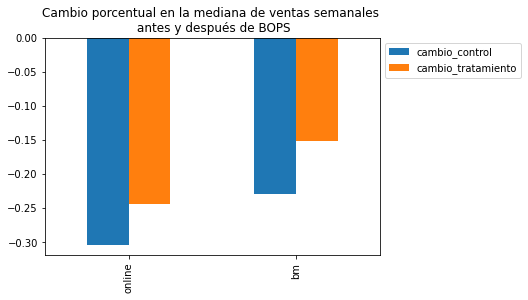

In [11]:
mediana_ventas_semana[['cambio_control', 'cambio_tratamiento']].plot(kind='bar', title='Cambio porcentual en la mediana de ventas semanales \n antes y después de BOPS')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [12]:
promedio_ventas_semana = pd.concat([regresa_resultados('online', control_online, tratamiento_online, 'mean'), regresa_resultados('bm', control_bm, tratamiento_bm, 'mean')])

In [13]:
promedio_ventas_semana

,num_semanas_after,before_BOPS_control,after_BOPS_control,cambio_control,before_BOPS_tratamiento,after_BOPS_tratamiento,cambio_tratamiento
online,25.0000,"1,558,447.7692","1,386,646.6000",-0.1102,"1,256,885.1923","1,082,283.6800",-0.1389
bm,27.0000,"1,034,979.7407","866,241.0741",-0.1630,"4,132,262.6296","3,698,465.8148",-0.1050


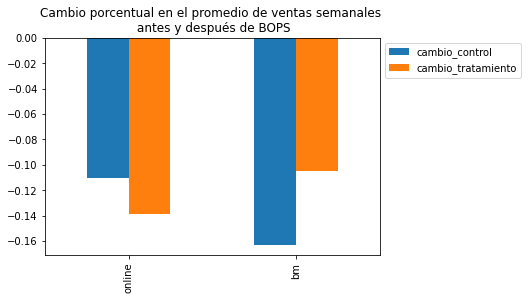

In [14]:
promedio_ventas_semana[['cambio_control', 'cambio_tratamiento']].plot(kind='bar', title='Cambio porcentual en el promedio de ventas semanales \n antes y después de BOPS')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Interpretación:
* Tanto en el grupo control como en el tratamiento se observo una caida en las ventas en el segundo periodo de observación (October 11, 2011–April 11, 2012)
* Al observar la mediana de precios por semana, observamos que la caída en ventas fue menor para el grupo tratamiento tanto online como B&M. Esto indicaría que la implementacion de BOPS fue exitosa porque ayudo reducir la caida en ventas
* Al observar el promedio de precios por semana observamos que la caída en ventas fue menor para el grupo tratamiento de B&M, mientras que para las operaciones online la caída en ventas fue  mayor para el grupo tratamiento. Los resultados no son concluyentes para este caso, sin embargo nos quedaremos con el inciso anterior porque como mencionamos arriba la mediana es una métrica más robusta y es preferible para este problema.

## Preguntas:
1. ¿Deberían expandirse a Canadá?

Si, por lo explicado en el apartado previo

2. ¿Cuántos millones de dólares se ganaron o perdieron a partir del programa?

De manera aproximada podríamos decir que se ganó todo lo que se hubiera perdido de no haber implemetando el programa (para el grupo tratamiento) menos el costo de la implementación. Entonces la fórmula queda asi:

**Ganancia aproximada** = Estimación de perdidas no ocurridas por semana * numero de semanas - costo de la implementación

Para estimar las pérdidas que hubieran ocurrido de no haberse implementado BOPS se aplicarán los porcentajes de cambio ocurridos en grupo control y la diferencia entre esto y lo que ocurrio será la estimación en ganancia semanal

In [15]:
mediana_ventas_semana['estimacion_after_sin_BOPS'] = mediana_ventas_semana['before_BOPS_tratamiento']*(1+ mediana_ventas_semana['cambio_control'])
mediana_ventas_semana['estimacion_ganancia_semanal'] = mediana_ventas_semana['after_BOPS_tratamiento'] - mediana_ventas_semana['estimacion_after_sin_BOPS']
mediana_ventas_semana['estimacion_ganancia'] = mediana_ventas_semana['estimacion_ganancia_semanal']* mediana_ventas_semana['num_semanas_after']

In [16]:
mediana_ventas_semana

,num_semanas_after,before_BOPS_control,after_BOPS_control,cambio_control,before_BOPS_tratamiento,after_BOPS_tratamiento,cambio_tratamiento,estimacion_after_sin_BOPS,estimacion_ganancia_semanal,estimacion_ganancia
online,25.0000,"1,561,343.0000","1,086,564.0000",-0.3041,"1,223,426.0000","924,223.0000",-0.2446,"851,402.0611","72,820.9389","1,820,523.4728"
bm,27.0000,"1,025,271.0000","790,660.0000",-0.2288,"4,113,463.0000","3,492,680.0000",-0.1509,"3,172,186.3347","320,493.6653","8,653,328.9627"


In [17]:
estimacion = mediana_ventas_semana.estimacion_ganancia.sum() #Numero prom de semanas para online y 

In [18]:
print(f"La ganancia aproximada por haber implementado BOPS es de ${estimacion:,.0f} menos el costo de la implementación de BOPS")

La ganancia aproximada por haber implementado BOPS es de $10,473,852 menos el costo de la implementación de BOPS
